# In-depth PSO parameter tuning

After having done some exploratory tuning on 3 months of data (see preliminary_pso_tuning_analysis.ipynb), I now tune the algorithm on 3 months * 3 currency pairs of data. 

The methodology remains the same as with the preliminary tuning: 

First, we isolate each parameter to test its influence on performance results and try to extract knowledge from it in the first part, 'parametric analysis'.

We then try to find some good combinations of these attributes in the second part, 'combinatorial analysis'.

Finally, we test the combinations, tune the most performing, and choose a final PSO configuration which we will use as the final product and use for the testing data.

## I. Parametric analysis

In [1]:
# Libraries and helper functions
import pickle
import json
import sys
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from toolz import get_config, get_all_config_results, plot_configs, get_algo_configurations

In [2]:
cfg = get_config(file='../config/training_config.json')
df = get_all_config_results(cfg, '../config/algos/pso_param_exp_configs.json')
acfg = get_algo_configurations('../config/algos/pso_param_exp_configs.json')

In [3]:
# Get mean values for each config
mean_by_config = pd.pivot_table(df, values=['value', 'mdd', 'no_of_transactions', 'realised_profit', 'ret', 'wealth'], columns=['config name'], aggfunc=np.mean)

## Swarm Size

We first analyse the influence of swarm size on fitness.

The swarm size parameter represents the number of particles in the swarm.
We create 4 configs: 

In [37]:
swarm_size_config_names = ['tiny swarm size', 'small swarm size', 'pso reference', 'medium high swarm size', 'high swarm size']
pd.DataFrame(acfg[swarm_size_config_names].loc['swarm_size']).T

tiny swarm size small swarm size pso reference  \
swarm_size               5               10            20   

           medium high swarm size high swarm size  
swarm_size                     40              80

And we test these configurations on the test data:

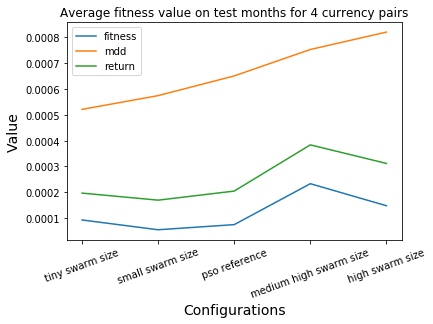

In [38]:
plot_configs(mean_by_config[swarm_size_config_names])

It seems that __as we increase the swarm size, the fitness increases__.

This could be explained by the fact that when we increase the swarm size, we give the algorithm more initial exploratory power, because more particles are spawned randomly on the search space and thus the chance that one of starts with a good fitness is increased. 

Furthermore, increasing the swarm size means that when the particles start to converge to an optimum, they have an increased exploitatory capacity since the higher the number of particles are in an optimum, the more the swarm can explore the optimum. This could also explain why we see a decrease in fitness when the swarm size is very high (`high swarm size`): when the swarm is too large, it exploits an optimum too much, yielding a candidate solution that might be very high in fitness on the training data, but overfits and thus looses fitness on the testing data.

The change in mdd is also interesting. Maybe an increase in mdd means an increase in profit, but strategies that are too high in mdd eventually loose fitness?

## Max Velocity Analysis
The `v_max` parameter represents the maximum value the velocity of a parameter in a particle can take.
We create 4 configs: 

In [39]:
max_velocity_config_names = ['low max velocity', 'medium max velocity', 'pso reference', 'medium high max velocity', 'high max velocity']
pd.DataFrame(acfg[max_velocity_config_names].loc['v_max']).T

low max velocity medium max velocity pso reference  \
v_max               10                  50           100   

      medium high max velocity high max velocity  
v_max                     1000               200

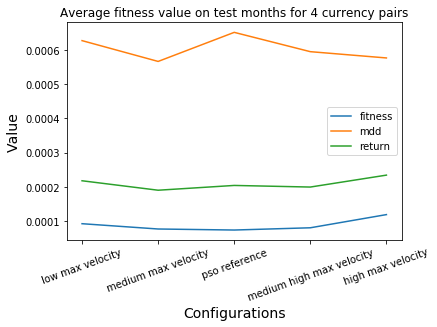

In [40]:
plot_configs(mean_by_config[max_velocity_config_names])

It seems that __by increasing max velocity, we get slightly better fitness results__

However, the change seems trivial. We check the values for fitness

In [41]:
mean_by_config[['low max velocity', 'medium max velocity', 'pso reference', 'medium high max velocity', 'high max velocity']].loc[['value', 'ret']]

config name  low max velocity  medium max velocity  pso reference  \
value                0.000092             0.000077       0.000074   
ret                  0.000218             0.000190       0.000204   

config name  medium high max velocity  high max velocity  
value                        0.000080           0.000119  
ret                          0.000199           0.000234

## Inertia weight
The `w_inertia` parameter represents the weight we accord to the particle's inertia when updating its velocity.
We create 4 configs:

In [43]:
inertia_config_names = ['lowest inertia weight', 'low inertia weight', 'medium low inertia weight', 'pso reference', 'medium high inertia weight', 'high inertia weight']
pd.DataFrame(acfg[inertia_config_names].loc['w_inertia']).T

lowest inertia weight low inertia weight medium low inertia weight  \
w_inertia                  0.05               0.25                      0.45   

          pso reference medium high inertia weight high inertia weight  
w_inertia          0.55                       0.75                0.95

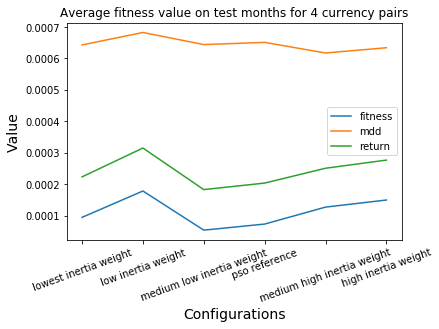

In [44]:
plot_configs(mean_by_config[inertia_config_names])

It seems that when the inertia weight is either low or high, we can see an increase in fitness. 

This could be explained by the fact that when the value of the inertia weight is low, our algorithm will favour exploration as the particles will be less inclined to converge. If the weight is too low, we have too little inertia and the particles yield optimums that are not exploited enough.

On the other hand, if our inertia weight is high, our particles will be more inclined to converge faster, and they exploit their optimums better, yielding higher fitness.

I speculated that if the inertia weight was too high, the particles would 'jump around' the search space too much and this would yield lower fitness values but the system seems to cope well (ie the velocity decreases enough over time)


## Memory weight
The `w_memory` parameter represents the weight we accord to the particle's best past position when updating its velocity and position.
We create 4 configs:

In [45]:
memory_config_names = ['lowest memory weight', 'low memory weight', 'medium low memory weight', 'pso reference', 'medium high memory weight', 'high memory weight']
pd.DataFrame(acfg[memory_config_names].loc['w_memory']).T

lowest memory weight low memory weight medium low memory weight  \
w_memory                 0.05              0.25                     0.45   

         pso reference medium high memory weight high memory weight  
w_memory          0.55                      0.75               0.95

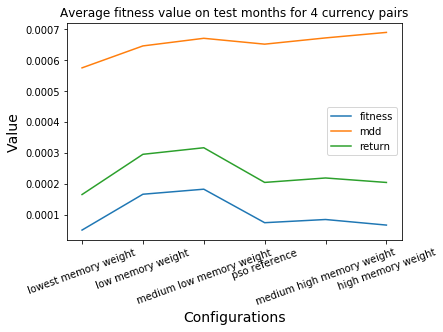

In [46]:
plot_configs(mean_by_config[memory_config_names])

For the memory weight, it seems that lower weights are more effective. If the weight is too high, the particles don't converge. On the other hand, if the weight is too low, the particles never explore their local surroundings.

## Neighbourhood weight
The `w_neigh` parameter represents the weight we accord to the particle's best past position when updating its velocity and position.
We create 4 configs:

In [47]:
neighbour_config_names = ['lowest neighbour weight', 'low neighbour weight', 'medium low neighbour weight', 'pso reference', 'medium high neighbour weight', 'high neighbour weight']
pd.DataFrame(acfg[neighbour_config_names].loc['w_neigh']).T

lowest neighbour weight low neighbour weight  \
w_neigh                    0.05                 0.25   

        medium low neighbour weight pso reference  \
w_neigh                        0.45          0.55   

        medium high neighbour weight high neighbour weight  
w_neigh                         0.75                  0.95

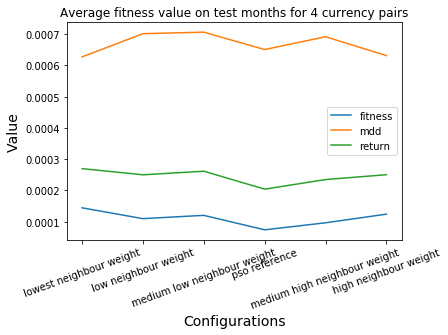

In [48]:
plot_configs(mean_by_config[neighbour_config_names])

In [49]:
mean_by_config[neighbour_config_names].loc[['value', 'mdd', 'ret']]

config name  lowest neighbour weight  low neighbour weight  \
value                       0.000144              0.000110   
mdd                         0.000627              0.000702   
ret                         0.000270              0.000250   

config name  medium low neighbour weight  pso reference  \
value                           0.000120       0.000074   
mdd                             0.000707       0.000651   
ret                             0.000261       0.000204   

config name  medium high neighbour weight  high neighbour weight  
value                            0.000096               0.000124  
mdd                              0.000692               0.000631  
ret                              0.000235               0.000250

Changes in neighbourhood weight don't seem too important. The return doesn't seem affected too much.

## K analysis
The `k` parameter represents the number of particles reaching the velocity convergence threshold needed to assume convergence;
We create 4 configs:

In [50]:
k_config_names = ['lowest k', 'low k', 'pso reference', 'medium k', 'high k', 'max k']
pd.DataFrame(acfg[k_config_names].loc['k']).T

lowest k low k pso reference medium k high k max k
k        1     3             5       10     15    20

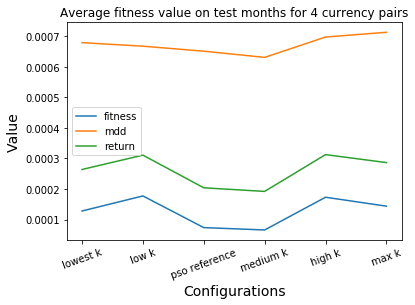

In [51]:
plot_configs(mean_by_config[k_config_names])

It seems that __when the value of k is either low or high, we can see an increase in fitness__

My interpretation of these results is that since k is a convergence criterion; when k is too low, we don't converge enough, when k is too high, we converge too much and overfit. Medium values don't perform well because they're neither global enough nor optimal enough.


## Velocity convergence threshold
If a particle's velocity update generates a difference in velocity lower than the `vel_conv_threshold` parameter, we assume that that particle has converged.
We create 4 configs:

In [52]:
vel_conv_config_names = ['lowest velocity convergence threshold', 'low velocity convergence threshold', 'medium velocity convergence threshold', 'pso reference', 'high velocity convergence threshold']
pd.DataFrame(acfg[vel_conv_config_names].loc['vel_conv_threshold']).T

lowest velocity convergence threshold  \
vel_conv_threshold                                 1e-06   

                   low velocity convergence threshold  \
vel_conv_threshold                              5e-05   

                   medium velocity convergence threshold pso reference  \
vel_conv_threshold                                0.0005         0.001   

                   high velocity convergence threshold  
vel_conv_threshold                                0.01

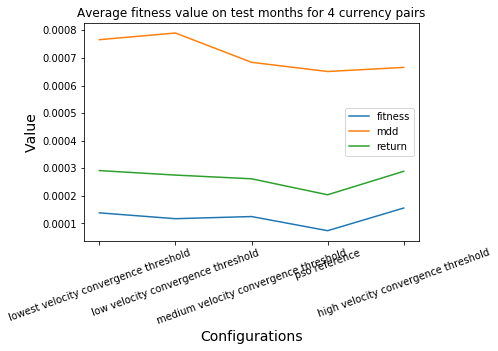

In [53]:
plot_configs(mean_by_config[vel_conv_config_names])

Same interpretation as k.

## Max iterations
The `max_iter` parameter the maximum number of velocity updates a swarm can make until we assume 'forced' convergence
We create 5 configs:

In [54]:
max_iter_config_names = ['lowest max iteration', 'low max iteration', 'pso reference', 'medium max iteration',  'high max iteration', 'max max iteration']
pd.DataFrame(acfg[max_iter_config_names].loc['max_iter']).T

lowest max iteration low max iteration pso reference  \
max_iter                    1                 3             5   

         medium max iteration high max iteration max max iteration  
max_iter                    7                 10                30

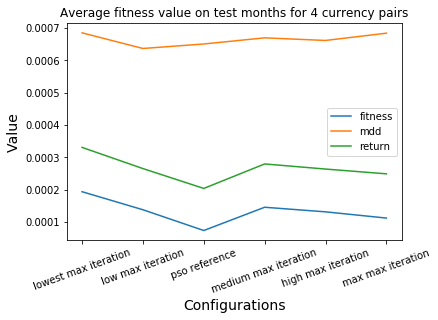

In [55]:
plot_configs(mean_by_config[max_iter_config_names])

Same interpretation as k.

## Conclusion

My conclusions are the same as on the preliminary explorations. Having more data allows me to be more assertive on the interpretations. 

I'll use the same configurations as in the first round of analysis, and see their performance on the test data.
I'll ignore the timing aspect for now, as I want to focus on finding good configurations, and assuming we have a whole day to train our data, we have more than enough time to train the algorithms according to my previous timing results. (time to train the `reference` configuration on 3 months of data for 1 currency: 84.93s user 14.93s system 75% cpu 2:11.92 total on a macbook pro)


# 2. Combinatorial analysis
So my first proposed configurations are:

### Exploratory rush
A big swarm that converges fast. We hope that at least one particle has a good initial fitness.
So high max velocity, high swarm size, high inertia weight, high neighbour weight

### Exploratory 
To favour exploration, we set a low neighbourhood weight, a medium memory weight, a high inertia weight, a low k, a low max iteration

### Exploitatory  
To favour exploitation, we set a high neighbourhood weight, a low memory weight, a medium inertia weight, a high k, a high max iteration

Both configs will have:
A medium high swarm size
A low vel conv threshold

The configurations are the following:

# In-depth PSO parameter tuning

After having done some exploratory tuning on 3 months of data (see preliminary_pso_tuning_analysis.ipynb), I now tune the algorithm on 3 months * 3 currency pairs of data. 

The methodology remains the same as with the preliminary tuning: 

First, we isolate each parameter to test its influence on performance results and try to extract knowledge from it in the first part, 'parametric analysis'.

We then try to find some good combinations of these attributes in the second part, 'combinatorial analysis'.

Finally, we test the combinations, tune the most performing, and choose a final PSO configuration which we will use as the final product and use for the testing data.

## I. Parametric analysis

In [81]:
get_algo_configurations('../config/algos/pso_configs_2.json')

rush               exploratory  \
base_results_file_path  results/pso/rush/  results/pso/exploratory/   
k                                      10                         6   
max_iter                                5                         7   
neighbourhood                           0                         0   
swarm_size                             40                        40   
v_max                                 200                       100   
vel_conv_threshold                 0.0001                     5e-05   
w_inertia                            0.75                      0.95   
w_memory                             0.55                      0.55   
w_neigh                              0.95                      0.05   

                                     exploitatory  
base_results_file_path  results/pso/exploitatory/  
k                                              20  
max_iter                                        7  
neighbourhood                                   0  
swarm_size                                     40  
v_max                                         200  
vel_conv_threshold                          5e-05  
w_inertia                                    0.55  
w_memory                                     0.05  
w_neigh                                      0.95

# 2. Combinatorial params analysis

### Testing the proposed configurations


In [56]:
df_c = get_all_config_results(cfg, '../config/algos/pso_configs_2.json')
# Get mean values for each config
mean_by_test_config = pd.pivot_table(df_c, values=['value', 'mdd', 'no_of_transactions', 'realised_profit', 'ret', 'wealth'], columns=['config name'], aggfunc=np.mean)
mean_by_test_config = mean_by_test_config.join(mean_by_config['pso reference'])
mean_by_test_config

exploitatory    exploratory           rush  pso reference
mdd                      0.000746       0.000861       0.000746       0.000651
no_of_transactions      21.426852      18.541667      19.475000      21.221429
realised_profit          1.218617       1.912381       1.630208       1.020076
ret                      0.000244       0.000382       0.000326       0.000204
value                    0.000095       0.000210       0.000177       0.000074
wealth              500001.218617  500001.912381  500001.630208  500001.020076

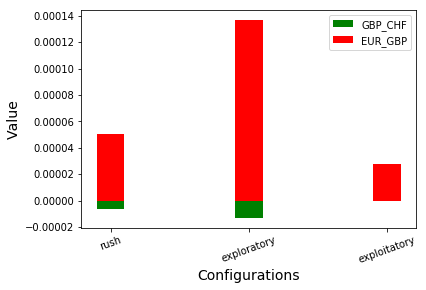

In [57]:
june_gc = df_c.loc[(df_c['data file'].str.contains("GBP_CHF")) & (df_c['month'] == '201306')]
june_gc.set_index('config name', inplace=True)
plt.bar(june_gc.index, june_gc['value'].values,  width=0.2,color='g', label='GBP_CHF', align='center')

june_eg = df_c.loc[(df_c['data file'].str.contains("EUR_GBP")) & (df_c['month'] == '201306')]
june_eg.set_index('config name', inplace=True)
plt.bar(june_gc.index, june_eg['value'].values,width=0.2,color='r', label='EUR_GBP', align='center')


plt.xticks(rotation=20)
plt.xlabel('Configurations', size=14)
plt.ylabel('Value', size=14)
plt.legend()
plt.show()

The exploratory configuration seems to perform very well. I decline it in different configurations to try and optimize it.

In [58]:
mean_by_config.idxmax(axis=1)

mdd                          high swarm size
no_of_transactions         max max iteration
realised_profit       medium high swarm size
ret                   medium high swarm size
value                 medium high swarm size
wealth                medium high swarm size
dtype: object

In [59]:
mean_by_config.sort_values('value', axis=1)

config name         lowest memory weight  small swarm size  \
mdd                             0.000574          0.000574   
no_of_transactions             20.994444         24.036111   
realised_profit                 0.824341          0.843860   
ret                             0.000165          0.000169   
value                           0.000050          0.000054   
wealth                     500000.824341     500000.843860   

config name         medium low inertia weight  high memory weight  \
mdd                                  0.000644            0.000689   
no_of_transactions                  22.258333           22.208333   
realised_profit                      0.916506            1.019489   
ret                                  0.000183            0.000204   
value                                0.000055            0.000066   
wealth                          500000.916506       500001.019489   

config name              medium k  pso reference  medium max velocity  \
mdd                      0.000631       0.000651             0.000566   
no_of_transactions      21.991667      21.221429            22.232143   
realised_profit          0.961332       1.020076             0.950238   
ret                      0.000192       0.000204             0.000190   
value                    0.000066       0.000074             0.000077   
wealth              500000.961332  500001.020076        500000.950238   

config name         medium high max velocity  medium high memory weight  \
mdd                                 0.000594                   0.000671   
no_of_transactions                 21.670238                  23.437037   
realised_profit                     0.996525                   1.091765   
ret                                 0.000199                   0.000218   
value                               0.000080                   0.000084   
wealth                         500000.996525              500001.091765   

config name         tiny swarm size           ...            high swarm size  \
mdd                        0.000521           ...                   0.000821   
no_of_transactions        22.824306           ...                  21.088194   
realised_profit            0.980676           ...                   1.556800   
ret                        0.000196           ...                   0.000311   
value                      0.000092           ...                   0.000147   
wealth                500000.980676           ...              500001.556800   

config name         high inertia weight  high velocity convergence threshold  \
mdd                            0.000634                             0.000666   
no_of_transactions            19.720833                            21.131481   
realised_profit                1.384977                             1.445595   
ret                            0.000277                             0.000289   
value                          0.000150                             0.000156   
wealth                    500001.384977                        500001.445595   

config name         low memory weight         high k          low k  \
mdd                          0.000645       0.000697       0.000667   
no_of_transactions          21.853704      21.016898      20.432672   
realised_profit              1.474333       1.563125       1.554240   
ret                          0.000295       0.000313       0.000311   
value                        0.000166       0.000173       0.000177   
wealth                  500001.474333  500001.563125  500001.554240   

config name         low inertia weight  medium low memory weight  \
mdd                           0.000682                  0.000670   
no_of_transactions           19.690741                 20.606481   
realised_profit               1.576596                  1.580359   
ret                           0.000315                  0.000316   
value                         0.000179                  0.000182   
wealth         

Medium high swarm size and exploratory are the best performing on the training data. They share the same parameter except for the number of iterations and weights. The medium high swarm size has the same weight for every param so it seems that what influences fitness is rather the swarm size/vmax/k ratio than the weights.

## Round 3
Since I have good fitness values on my exploratory configuration, I propose a number of variant configurations of it, as well as some variants of the 'medium high swarm size' configuration. 

To create the variants, I randomly changed the parameters of the two strategies to create similar strategies that varied only a little on their parameters. 

In [4]:
df3 = get_all_config_results(cfg, '../config/algos/pso_configs_3.json')
df_c = get_all_config_results(cfg, '../config/algos/pso_configs_2.json')

mean_by_config_3 = pd.pivot_table(df3, values=['value', 'mdd', 'no_of_transactions', 'realised_profit', 'ret', 'wealth'], columns=['config name'], aggfunc=np.mean)
mean_by_config = mean_by_config.join(mean_by_config_3)
mean_by_config.sort_values('value', axis=1)

config name         lowest memory weight  small swarm size  \
mdd                             0.000574          0.000574   
no_of_transactions             20.994444         24.036111   
realised_profit                 0.824341          0.843860   
ret                             0.000165          0.000169   
value                           0.000050          0.000054   
wealth                     500000.824341     500000.843860   

config name         medium low inertia weight  high memory weight  \
mdd                                  0.000644            0.000689   
no_of_transactions                  22.258333           22.208333   
realised_profit                      0.916506            1.019489   
ret                                  0.000183            0.000204   
value                                0.000055            0.000066   
wealth                          500000.916506       500001.019489   

config name              medium k  pso reference  medium max velocity  \
mdd                      0.000631       0.000651             0.000566   
no_of_transactions      21.991667      21.221429            22.232143   
realised_profit          0.961332       1.020076             0.950238   
ret                      0.000192       0.000204             0.000190   
value                    0.000066       0.000074             0.000077   
wealth              500000.961332  500001.020076        500000.950238   

config name         medium high max velocity  medium high memory weight  \
mdd                                 0.000594                   0.000671   
no_of_transactions                 21.670238                  23.437037   
realised_profit                     0.996525                   1.091765   
ret                                 0.000199                   0.000218   
value                               0.000080                   0.000084   
wealth                         500000.996525              500001.091765   

config name         tiny swarm size      ...        exploratory 6  \
mdd                        0.000521      ...             0.000744   
no_of_transactions        22.824306      ...            20.925000   
realised_profit            0.980676      ...             1.665339   
ret                        0.000196      ...             0.000333   
value                      0.000092      ...             0.000184   
wealth                500000.980676      ...        500001.665339   

config name         medium high swarm size 4  exploratory 1  exploratory 2  \
mdd                                 0.000710       0.000794       0.000795   
no_of_transactions                 19.822619      16.846296      19.256481   
realised_profit                     1.643033       1.740798       1.751922   
ret                                 0.000329       0.000348       0.000350   
value                               0.000187       0.000189       0.000191   
wealth                         500001.643033  500001.740798  500001.751922   

config name         lowest max iteration  exploratory 3  \
mdd                             0.000685       0.000829   
no_of_transactions             20.677083      17.252778   
realised_profit                 1.654814       1.991195   
ret                             0.000331       0.000398   
value                           0.000194       0.000232   
wealth                     500001.654814  500001.991195   

config name         medium high swarm size  medium high swarm size 2  \
mdd                               0.000753                  0.000693   
no_of_transactions               18.380423                 19.622222   
realised_profit                   1.916279                  1.868446   
ret                               0.000383                  0.000374   
value                             0.000233                  0.000235   
wealth                       500001.916279             500001.868446   

config name         medium high swarm size 1  exploratory 4  
mdd                            

## Friedman test
The results on this third round of tuning seem very satisfactory, so I export the data to csv files in order to apply some statistical tests on the results to see if the difference in results for each strategy is significant or not. 

To do this, I aggregate all of my configurations, and 

In [5]:
df3 = get_all_config_results(cfg, '../config/algos/pso_configs_3.json')
df2 = get_all_config_results(cfg, '../config/algos/pso_configs_2.json')
df = get_all_config_results(cfg, '../config/algos/pso_param_exp_configs.json')
all_configs = pd.concat([df, df2, df3])

In [6]:
all_meaned_configs = pd.pivot_table(all_configs, values=['value', 'mdd', 'no_of_transactions', 'realised_profit', 'ret', 'wealth'], columns=['config name'], aggfunc=np.mean)
all_meaned_configs.sort_values('value', axis=1)

config name         lowest memory weight  small swarm size  \
mdd                             0.000574          0.000574   
no_of_transactions             20.994444         24.036111   
realised_profit                 0.824341          0.843860   
ret                             0.000165          0.000169   
value                           0.000050          0.000054   
wealth                     500000.824341     500000.843860   

config name         medium low inertia weight  high memory weight  \
mdd                                  0.000644            0.000689   
no_of_transactions                  22.258333           22.208333   
realised_profit                      0.916506            1.019489   
ret                                  0.000183            0.000204   
value                                0.000055            0.000066   
wealth                          500000.916506       500001.019489   

config name              medium k  pso reference  medium max velocity  \
mdd                      0.000631       0.000651             0.000566   
no_of_transactions      21.991667      21.221429            22.232143   
realised_profit          0.961332       1.020076             0.950238   
ret                      0.000192       0.000204             0.000190   
value                    0.000066       0.000074             0.000077   
wealth              500000.961332  500001.020076        500000.950238   

config name         medium high max velocity  medium high memory weight  \
mdd                                 0.000594                   0.000671   
no_of_transactions                 21.670238                  23.437037   
realised_profit                     0.996525                   1.091765   
ret                                 0.000199                   0.000218   
value                               0.000080                   0.000084   
wealth                         500000.996525              500001.091765   

config name         tiny swarm size      ...        medium high swarm size 4  \
mdd                        0.000521      ...                        0.000710   
no_of_transactions        22.824306      ...                       19.822619   
realised_profit            0.980676      ...                        1.643033   
ret                        0.000196      ...                        0.000329   
value                      0.000092      ...                        0.000187   
wealth                500000.980676      ...                   500001.643033   

config name         exploratory 1  exploratory 2  lowest max iteration  \
mdd                      0.000794       0.000795              0.000685   
no_of_transactions      16.846296      19.256481             20.677083   
realised_profit          1.740798       1.751922              1.654814   
ret                      0.000348       0.000350              0.000331   
value                    0.000189       0.000191              0.000194   
wealth              500001.740798  500001.751922         500001.654814   

config name           exploratory  exploratory 3  medium high swarm size  \
mdd                      0.000861       0.000829                0.000753   
no_of_transactions      18.541667      17.252778               18.380423   
realised_profit          1.912381       1.991195                1.916279   
ret                      0.000382       0.000398                0.000383   
value                    0.000210       0.000232                0.000233   
wealth              500001.912381  500001.991195           500001.916279   

config name         medium high swarm size 2  medium high swarm size 1  \
mdd                                 0.000693                  0.000737   
no_of_transactions                 19.622222                 19.158333   
realised_profit                     1.868446                  1.923701   
ret                                 0.000374                  0.000385   
value                               0.000235                

In [7]:
bests = all_configs.loc[all_configs['config name'].isin(['exploratory 4', 'medium high swarm size 1', 'medium high swarm size 2', 'medium high swarm size', 'exploratory 3', 'exploratory', 'lowest max iteration', 'exploratory 2', 'exploratory 1', 'medium high swarm size 4' ])]

In [8]:
ndf = bests[['data file', 'config name', 'value']]
ndf = ndf.pivot_table(index='data file', columns='config name', values='value')
ndf.to_csv('../tests/friedman_particles.csv', sep=',')

In [9]:
len(all_meaned_configs.columns)

51

In [66]:
bests.to_csv('../results/best_particles.csv', sep=',')

In [67]:
best_meaned_configs = pd.pivot_table(bests, values=['value', 'mdd', 'no_of_transactions', 'realised_profit', 'ret', 'wealth'], columns=['config name'], aggfunc=np.mean)
best_meaned_configs.to_csv('../results/best_meaned_particles.csv', sep=',')

# Friedman test results
The friedman statistical test ranked the ```exploratory 1``` as being the best strategy. I feel like there is a big disparity between exploratory 1 and exploratory 4 in terms of avg return in the test data.
The p-value was 0.7360415692660789 which is very high: it means that we only have a 23% certainty that e1 outperforms e4

As a result I analyse the two strategies to make a better decision:

In [68]:
e1 = all_configs.loc[all_configs['config name'] == 'exploratory 1']
e4 = all_configs.loc[all_configs['config name'] == 'exploratory 4']
e4_EUR_GBP = e4.loc[e4['data file'].str.contains('EUR_GBP')].set_index('month').mean()
e1_EUR_GBP = e1.loc[e1['data file'].str.contains('EUR_GBP')].set_index('month').mean()
e4_GBP_CHF = e4.loc[e4['data file'].str.contains('GBP_CHF')].set_index('month').mean()
e1_GBP_CHF = e1.loc[e1['data file'].str.contains('GBP_CHF')].set_index('month').mean()
e4_EUR_USD = e4.loc[e4['data file'].str.contains('EUR_USD')].set_index('month').mean()
e1_EUR_USD = e1.loc[e1['data file'].str.contains('EUR_USD')].set_index('month').mean()
e4_GBP_USD = e4.loc[e4['data file'].str.contains('GBP_USD')].set_index('month').mean()
e1_GBP_USD = e1.loc[e1['data file'].str.contains('GBP_USD')].set_index('month').mean()
vals = pd.DataFrame(index=['e4', 'e1'], columns=['EUR_GBP', 'GBP_CHF', 'EUR_USD', 'GBP_USD'])
vals.loc['e4'] = [e4_EUR_GBP['value'], e4_GBP_CHF['value'], e4_EUR_USD['value'], e4_GBP_USD['value']]
vals.loc['e1'] = [e1_EUR_GBP['value'], e1_GBP_CHF['value'], e1_EUR_USD['value'], e1_GBP_USD['value']]

mdds = pd.DataFrame(index=['e4', 'e1'], columns=['EUR_GBP', 'GBP_CHF', 'EUR_USD', 'GBP_USD'])
mdds.loc['e4'] = [e4_EUR_GBP['mdd'], e4_GBP_CHF['mdd'], e4_EUR_USD['mdd'], e4_GBP_USD['mdd']]
mdds.loc['e1'] = [e1_EUR_GBP['mdd'], e1_GBP_CHF['mdd'], e1_EUR_USD['mdd'], e1_GBP_USD['mdd']]

rets = pd.DataFrame(index=['e4', 'e1'], columns=['EUR_GBP', 'GBP_CHF', 'EUR_USD', 'GBP_USD'])
rets.loc['e4'] = [e4_EUR_GBP['ret'], e4_GBP_CHF['ret'], e4_EUR_USD['ret'], e4_GBP_USD['ret']]
rets.loc['e1'] = [e1_EUR_GBP['ret'], e1_GBP_CHF['ret'], e1_EUR_USD['ret'], e1_GBP_USD['ret']]

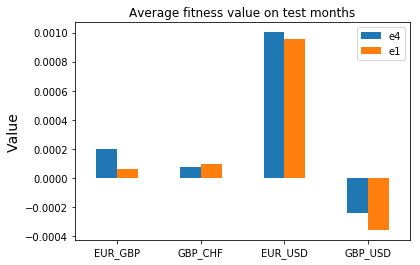

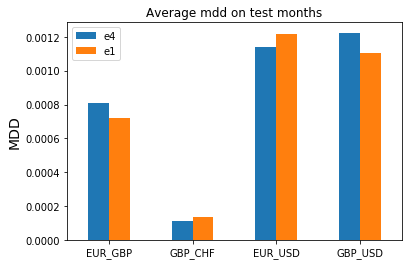

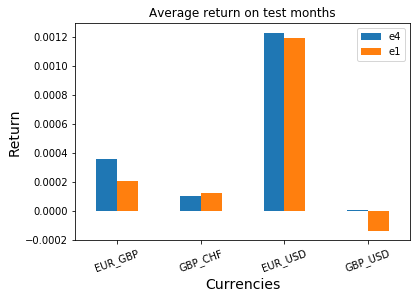

In [69]:
vals.transpose().plot.bar(rot=0)
plt.title("Average fitness value on test months")
plt.ylabel('Value', size=14)

mdds.transpose().plot.bar(rot=0)
plt.title("Average mdd on test months")
plt.ylabel('MDD', size=14)

rets.transpose().plot.bar(rot=0)
plt.title("Average return on test months")
plt.ylabel('Return', size=14)

plt.xticks(rotation=20)
plt.xlabel('Currencies', size=14)
plt.legend()
plt.show()

With these graphs, we can see that e4 seems more advantageous.

    - It yields better fitness on 3 out of 4 currency pairs.
    - Its mdd is not necessarily always higher
    - It yields profitable return on all currency pairs. (see following value for the GBP-USD pair:)

In [70]:
rets.loc['e4']['GBP_USD']

7.967419954646316e-06

As a result, I choose the exploratory 4 configuration as my PSO configuration.